# Hollweg Dispersion Solver

[tfds]: ../../api/plasmapy.dispersion.numerical.hollweg_.hollweg.rst
[bellan2012]: https://doi.org/10.1029/2012JA017856
[hollweg1999]: https://doi.org/10.1029/1998JA900132

This notebook details the functionality of the [hollweg()][tfds] function.  This function computes the wave frequencies for given wavenumbers and plasma parameters based on the solution to the two fluid dispersion relation presented by [Hollweg 1999][hollweg1999], and further summarized by [Bellan 2012][bellan2012].  In his derivation Hollweg assumed a uniform magnetic field, zero D.C electric field, quasi-neutrality, and low-frequency waves ($\omega \ll \omega_{ci}$), which yielded the following expression

$$
    \left( \frac{\omega^2}{{k_z}^2 {v_A}^2} - 1 \right)
    \left[\omega^2
        \left(\omega^2 - k^2 {v_A}^2 \right)
        - \beta k^2 {v_A}^2 \left( \omega^2 - {k_z}^2 {v_A}^2 \right)
    \right] \\
    = \omega^2 \left(\omega^2 - k^2 {v_A}^2 \right) {k_x}^2 \left(
    \frac{{c_s}^2}{{\omega_{ci}}^2} - \frac{c^2}{{\omega_{pe}}^2}
    \frac{\omega^2}{{k_z}^2 {v_A}^2} \right)
$$

where

$$\beta = c_{s}^2 / v_{A}^2$$

$$k_{x} = k \sin \theta$$

$$k_{z} = k \cos \theta$$

$$\mathbf{B_{o}} = B_{o} \mathbf{\hat{z}}$$

$\omega$ is the wave frequency, $k$ is the wavenumber
, $v_{A}$ is the Alfvén velocity, $c_{s}$ is the ion
sound speed, $\omega_{ci}$ is the ion gyrofrequency, and
$\omega_{pe}$ is the electron plasma frequency.

<div class="alert alert-info">
Note

[Hollweg 1999][hollweg1999] asserts this expression is valid for arbitrary $c_{s} / v_{A}$ and $k_{z} / k$. Contrarily, [Bellan 2012][bellan2012] states in  Section 1.7 that due to the inconsistent retention of the $\omega / \omega_{ci} \ll 1$ terms the expression can only be valid if both $c_{s} \ll v_{A}$ and the wave propgation is nearly perpendicular to the magnetic field ($|\theta - \pi/2| \ll 1$ radians).
</div>

The [hollweg()][tfds] function numerically solves for the roots of this equation, which correspond to the Fast, Alfvén, and Acoustic wave modes.

## Contents:

1. [Wave propogating at nearly 90 degrees](#Wave-propogating-at-nearly-90-degrees)
2. [Hollweg 1999 and Bellan 2012 comparsion](#Hollweg-1999-and-Bellan-2012-comparison)
3. [Reproduce Figure 2 from Hollweg 1999](#Reproduce-Figure-2-from-Hollweg-1999)

In [4]:
%matplotlib inline

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import warnings

from astropy.constants.si import c
from matplotlib.ticker import MultipleLocator

from plasmapy.dispersion.analytical.two_fluid_ import two_fluid
from plasmapy.dispersion.numerical.hollweg_ import hollweg
from plasmapy.formulary.frequencies import gyrofrequency, plasma_frequency, wc_, wp_
from plasmapy.formulary.lengths import inertial_length
from plasmapy.formulary.speeds import Alfven_speed, cs_, ion_sound_speed, va_
from plasmapy.particles import Particle

warnings.filterwarnings(action="ignore")

plt.rcParams["figure.figsize"] = [10.5, 0.56 * 10.5]

## Wave propogating at nearly 90 degrees

Below we define the required parameters to compute the wave frequencies.

In [5]:
# define input parameters
inputs = {
    "k": np.logspace(-7, -2, 300) * u.rad / u.m,
    "theta": 89 * u.deg,
    "n_i": 5 * u.cm ** -3,
    "B": 1.10232e-8 * u.T,
    "T_e": 1.6e6 * u.K,
    "T_i": 4.0e5 * u.K,
    "ion": Particle("p+"),
}

# a few useful plasma parameters
params = {
    "n_e": inputs["n_i"] * abs(inputs["ion"].charge_number),
    "cs": ion_sound_speed(
        inputs["T_e"],
        inputs["T_i"],
        inputs["ion"],
    ),
    "va": Alfven_speed(
        inputs["B"],
        inputs["n_i"],
        ion=inputs["ion"],
    ),
    "wci": gyrofrequency(inputs["B"], inputs["ion"]),
}
params["lpe"] = inertial_length(params["n_e"], "e-")
params["wpe"] = plasma_frequency(params["n_e"], "e-")

The computed wave frequencies ($rad/s$) are returned in a dictionary with the keys representing
wave modes and the values being an Astropy [Quantity](https://docs.astropy.org/en/stable/api/astropy.units.Quantity.html#astropy.units.Quantity). Since our inputs were a 1D arrays of
of $k$'s, the computed wave frequencies will be a 1D array of size equal to the size of the $k$ array.

In [6]:
# compute
omegas1 = hollweg(**inputs)
omegas2 = two_fluid(**inputs)
(list(omegas1.keys()), omegas1["fast_mode"], omegas1["fast_mode"].shape)

(['fast_mode', 'alfven_mode', 'acoustic_mode'],
 <Quantity [1.86187553e-02+0.j, 1.93496472e-02+0.j, 2.01092308e-02+0.j,
            2.08986324e-02+0.j, 2.17190225e-02+0.j, 2.25716175e-02+0.j,
            2.34576817e-02+0.j, 2.43785290e-02+0.j, 2.53355248e-02+0.j,
            2.63300881e-02+0.j, 2.73636936e-02+0.j, 2.84378740e-02+0.j,
            2.95542221e-02+0.j, 3.07143932e-02+0.j, 3.19201076e-02+0.j,
            3.31731531e-02+0.j, 3.44753878e-02+0.j, 3.58287426e-02+0.j,
            3.72352242e-02+0.j, 3.86969182e-02+0.j, 4.02159920e-02+0.j,
            4.17946981e-02+0.j, 4.34353773e-02+0.j, 4.51404625e-02+0.j,
            4.69124819e-02+0.j, 4.87540631e-02+0.j, 5.06679368e-02+0.j,
            5.26569409e-02+0.j, 5.47240247e-02+0.j, 5.68722532e-02+0.j,
            5.91048118e-02+0.j, 6.14250109e-02+0.j, 6.38362910e-02+0.j,
            6.63422275e-02+0.j, 6.89465361e-02+0.j, 7.16530786e-02+0.j,
            7.44658680e-02+0.j, 7.73890754e-02+0.j, 8.04270351e-02+0.j,
            8.35

Let's plot the results of each wave mode.

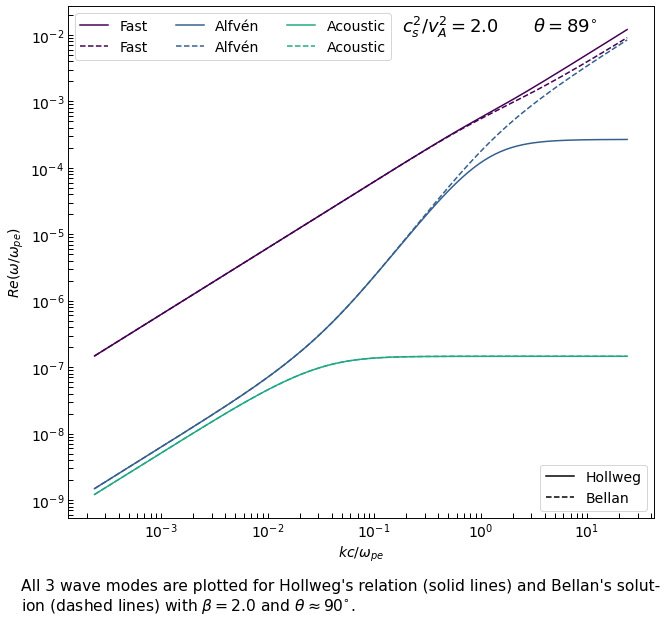

In [7]:
fs = 14  # default font size
figwidth, figheight = plt.rcParams["figure.figsize"]
figheight = 1.6 * figheight
fig = plt.figure(figsize=[figwidth, figheight])

# normalize data
k_prime = inputs["k"] * params["lpe"]

# define colormap
cmap = plt.get_cmap("viridis")
slicedCM = cmap(np.linspace(0, 0.6, 3))

# plot
(p1,) = plt.plot(
    k_prime,
    np.real(omegas1["fast_mode"] / params["wpe"]),
    "--",
    c=slicedCM[0],
    ms=1,
    label="Fast",
)
ax = plt.gca()
(p2,) = ax.plot(
    k_prime,
    np.real(omegas1["alfven_mode"] / params["wpe"]),
    "--",
    c=slicedCM[1],
    ms=1,
    label="Alfvén",
)
(p3,) = ax.plot(
    k_prime,
    np.real(omegas1["acoustic_mode"] / params["wpe"]),
    "--",
    c=slicedCM[2],
    ms=1,
    label="Acoustic",
)
(p4,) = plt.plot(
    k_prime,
    np.real(omegas2["fast_mode"] / params["wpe"]),
    c=slicedCM[0],
    ms=1,
    label="Fast",
)
ax = plt.gca()
(p5,) = ax.plot(
    k_prime,
    np.real(omegas2["alfven_mode"] / params["wpe"]),
    c=slicedCM[1],
    ms=1,
    label="Alfvén",
)
(p6,) = ax.plot(
    k_prime,
    np.real(omegas2["acoustic_mode"] / params["wpe"]),
    c=slicedCM[2],
    ms=1,
    label="Acoustic",
)

# adjust axes
ax.set_xlabel(r"$kc / \omega_{pe}$", fontsize=fs)
ax.set_ylabel(r"$Re(\omega / \omega_{pe})$", fontsize=fs)
ax.set_yscale("log")
ax.set_xscale("log")
# ax.set_ylim(1e-2, 1e4)
ax.tick_params(
    which="both",
    direction="in",
    width=1,
    labelsize=fs,
    right=True,
    length=5,
)

# annotate
styles = ["-", "--"]
s_labels = ["Hollweg", "Bellan"]
ax2 = ax.twinx()
for ss, lab in enumerate(styles):
    ax2.plot(np.NaN, np.NaN, ls=styles[ss], label=s_labels[ss], c="black")
ax2.get_yaxis().set_visible(False)
ax2.legend(fontsize=14, loc="lower right")

text1 = (
    f"$c_s^2/v_A^2 = {params['cs'] ** 2 / params['va'] ** 2:.1f} \qquad "
    f"\\theta = {inputs['theta'].value:.0f}"
    "^{\\circ}$"
)
text2 = (
    "All 3 wave modes are plotted for Hollweg's relation (solid lines) and Bellan's solut- \n"
    "ion (dashed lines) with $\\beta = 2.0$ and $\\theta \\approx 90^{\\circ}$."
)
plt.figtext(-0.08, -0.18, text2, ha="left", transform=ax.transAxes, fontsize=15.5)
ax.text(0.57, 0.95, text1, transform=ax.transAxes, fontsize=18)
ax.legend(handles=[p4, p1, p5, p2, p6, p3], fontsize=14, ncol=3, loc="upper left")

## Hollweg 1999 and Bellan 2012 comparison

[bellan2012]: https://doi.org/10.1029/2012JA017856

Figure 1 of [Bellan 2012][bellan2012] chooses parameters such that
$\beta = 0.4$ and $\Lambda = 0.4$. Below we define parameters to
approximate Bellan's assumptions.

In [8]:
# define input parameters
inputs = {
    "B": 400e-4 * u.T,
    "ion": Particle("He+"),
    "n_i": 6.358e19 * u.m ** -3,
    "T_e": 20 * u.eV,
    "T_i": 10 * u.eV,
    "theta": np.linspace(0, 90) * u.deg,
    "k": (2 * np.pi * u.rad) / (0.56547 * u.m),
}

# a few useful plasma parameters
params = {
    "n_e": inputs["n_i"] * abs(inputs["ion"].charge_number),
    "cs": cs_(inputs["T_e"], inputs["T_i"], inputs["ion"]),
    "wci": wc_(inputs["B"], inputs["ion"]),
    "va": va_(inputs["B"], inputs["n_i"], ion=inputs["ion"]),
}
params["beta"] = (params["cs"] / params["va"]).value ** 2
params["wpe"] = wp_(params["n_e"], "e-")
params["Lambda"] = (inputs["k"] * params["va"] / params["wci"]).value ** 2

(params["beta"], params["Lambda"])

(0.4000832135717194, 0.4000017351804854)

In [9]:
# compute omegas for Bellan
bellan_omegas = two_fluid(**inputs)

# compute omegas for Hollweg
fast = []
alfven = []
acoustic = []
for val in inputs["theta"]:
    hollweg_inputs = {
        **inputs,
        "theta": val,
    }
    fast.append(hollweg(**hollweg_inputs)["fast_mode"].value)
    alfven.append(hollweg(**hollweg_inputs)["alfven_mode"].value)
    acoustic.append(hollweg(**hollweg_inputs)["acoustic_mode"].value)
hollweg_omegas = {
    "fast_mode": fast * u.rad / u.s,
    "alfven_mode": alfven * u.rad / u.s,
    "acoustic_mode": acoustic * u.rad / u.s,
}

In [10]:
# generate data for Bellan curves
bellan_plt_vals = {}
for mode, arr in bellan_omegas.items():
    norm = (np.absolute(arr) / (inputs["k"] * params["va"])).value ** 2
    bellan_plt_vals[mode] = {
        "x": norm * np.sin(inputs["theta"].to(u.rad).value),
        "y": norm * np.cos(inputs["theta"].to(u.rad).value),
    }

# generate data for Hollweg curves
hollweg_plt_vals = {}
for mode, arr in hollweg_omegas.items():
    norm = (np.absolute(arr) / (inputs["k"] * params["va"])).value ** 2
    hollweg_plt_vals[mode] = {
        "x": norm * np.sin(inputs["theta"].to(u.rad).value),
        "y": norm * np.cos(inputs["theta"].to(u.rad).value),
    }

Let's plot all 3 wave modes

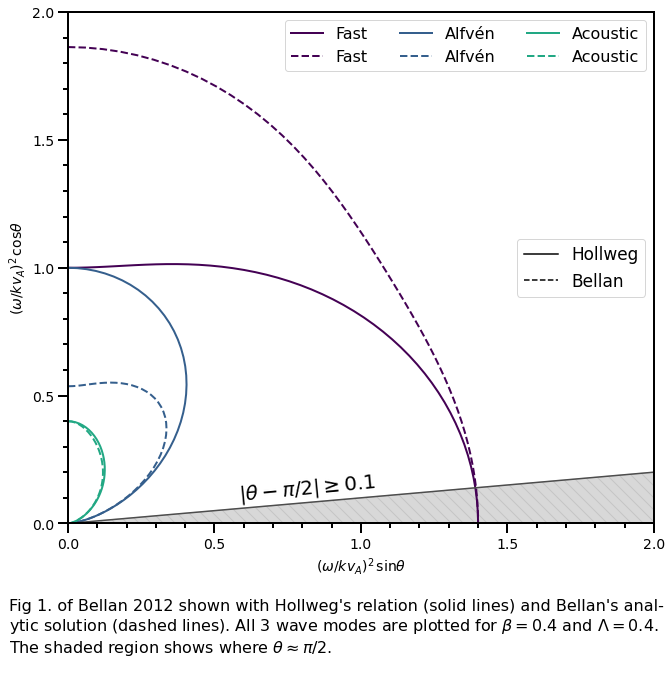

In [11]:
fs = 14  # default font size
figwidth, figheight = plt.rcParams["figure.figsize"]
figheight = 1.6 * figheight
fig = plt.figure(figsize=[figwidth, figheight])

# define colormap
cmap = plt.get_cmap("viridis")
slicedCM = cmap(np.linspace(0, 0.6, 3))

# Bellan Fast mode
(p1,) = plt.plot(
    bellan_plt_vals["fast_mode"]["x"],
    bellan_plt_vals["fast_mode"]["y"],
    "--",
    c=slicedCM[0],
    linewidth=2,
    label="Fast",
)
ax = plt.gca()

# adjust axes
ax.set_xlabel(r"$(\omega / k v_{A})^{2} \, \sin \theta$", fontsize=fs)
ax.set_ylabel(r"$(\omega / k v_{A})^{2} \, \cos \theta$", fontsize=fs)
ax.set_xlim(0.0, 2.0)
ax.set_ylim(0.0, 2.0)
for spine in ax.spines.values():
    spine.set_linewidth(2)
ax.minorticks_on()
ax.tick_params(which="both", labelsize=fs, width=2)
ax.tick_params(which="major", length=10)
ax.tick_params(which="minor", length=5)
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))

# Bellan Alfven mode
(p2,) = plt.plot(
    bellan_plt_vals["alfven_mode"]["x"],
    bellan_plt_vals["alfven_mode"]["y"],
    "--",
    c=slicedCM[1],
    linewidth=2,
    label="Alfvén",
)

# Bellan Acoustic mode
(p3,) = plt.plot(
    bellan_plt_vals["acoustic_mode"]["x"],
    bellan_plt_vals["acoustic_mode"]["y"],
    "--",
    c=slicedCM[2],
    linewidth=2,
    label="Acoustic",
)

# Hollweg Fast mode
(p4,) = plt.plot(
    hollweg_plt_vals["fast_mode"]["x"],
    hollweg_plt_vals["fast_mode"]["y"],
    c=slicedCM[0],
    linewidth=2,
    label="Fast",
)

# Hollweg Alfven mode
(p5,) = plt.plot(
    hollweg_plt_vals["alfven_mode"]["x"],
    hollweg_plt_vals["alfven_mode"]["y"],
    c=slicedCM[1],
    linewidth=2,
    label="Alfvén",
)

# Hollweg Acoustic mode
(p6,) = plt.plot(
    hollweg_plt_vals["acoustic_mode"]["x"],
    hollweg_plt_vals["acoustic_mode"]["y"],
    c=slicedCM[2],
    linewidth=2,
    label="Acoustic",
)

# annotations
r = np.linspace(0, 2, 200)
X = (r ** 2) * (np.sin(np.pi / 2 - 0.1))
Y = (r ** 2) * (np.cos(np.pi / 2 - 0.1))
plt.plot(X, Y, color="0.3")
ax.fill_between(X, 0, Y, hatch="\\\\", color="0.7", alpha=0.5)

# style legend
styles = ["-", "--"]
s_labels = ["Hollweg", "Bellan"]
ax2 = ax.twinx()
for ss, lab in enumerate(styles):
    ax2.plot(np.NaN, np.NaN, ls=styles[ss], label=s_labels[ss], c="black")
ax2.get_yaxis().set_visible(False)
ax2.legend(fontsize=17, loc="center right")

ax.legend(handles=[p4, p1, p5, p2, p6, p3], fontsize=16, ncol=3, loc="upper right")
plt.figtext(0.35, 0.16, "$|\\theta - \\pi / 2| \geq 0.1$", rotation=5.5, fontsize=20)

# plot caption
txt = (
    "Fig 1. of Bellan 2012 shown with Hollweg's relation (solid lines) and Bellan's anal-\n"
    "ytic solution (dashed lines). All 3 wave modes are plotted for $\\beta= 0.4$ and $\\Lambda= 0.4$.\n"
    "The shaded region shows where $\\theta \\approx \\pi / 2$.\n"
)

plt.figtext(-0.1, -0.29, txt, ha="left", transform=ax.transAxes, fontsize=16);

## Reproduce Figure 2 from Hollweg 1999

[hollweg1999]: https://doi.org/10.1029/1998JA900132

Figure 2 of [Hollweg 1999][hollweg1999] plots the Alfvén mode
and chooses parameters such that $\beta = 1/20, 1/2, 2, 1/2000$.
Below we define parameters to approximate these values.

In [12]:
# define input parameters
# beta = 1/20
inputs0 = {
    "k": np.logspace(-7, -2, 400) * u.rad / u.m,
    "theta": 90 * u.deg,
    "n_i": 5 * u.cm ** -3,
    "B": 6.971e-8 * u.T,
    "T_e": 1.6e6 * u.K,
    "T_i": 4.0e5 * u.K,
    "ion": Particle("p+"),
}
# beta = 1/2
inputs1 = {
    **inputs0,
    "B": 2.205e-8 * u.T,
}
# beta = 2
inputs2 = {
    **inputs0,
    "B": 1.10232e-8 * u.T,
}
# beta = 1/2000
inputs3 = {
    **inputs0,
    "B": 6.97178e-7 * u.T,
}

# a few useful plasma parameters

# parameters corresponding to inputs0
params0 = {
    "n_e": inputs0["n_i"] * abs(inputs0["ion"].charge_number),
    "cs": ion_sound_speed(
        inputs0["T_e"],
        inputs0["T_i"],
        inputs0["ion"],
    ),
    "va": Alfven_speed(
        inputs0["B"],
        inputs0["n_i"],
        ion=inputs0["ion"],
    ),
    "wci": gyrofrequency(inputs0["B"], inputs0["ion"]),
}
params0["lpe"] = inertial_length(params0["n_e"], "e-")
params0["wpe"] = plasma_frequency(params0["n_e"], "e-")
params0["L"] = params0["cs"] / abs(params0["wci"])

# parameters corresponding to inputs1
params1 = {
    "n_e": inputs1["n_i"] * abs(inputs1["ion"].charge_number),
    "cs": ion_sound_speed(
        inputs1["T_e"],
        inputs1["T_i"],
        inputs1["ion"],
    ),
    "va": Alfven_speed(
        inputs1["B"],
        inputs1["n_i"],
        ion=inputs1["ion"],
    ),
    "wci": gyrofrequency(inputs1["B"], inputs1["ion"]),
}
params1["lpe"] = inertial_length(params1["n_e"], "e-")
params1["wpe"] = plasma_frequency(params1["n_e"], "e-")
params1["L"] = params1["cs"] / abs(params1["wci"])

# parameters corresponding to inputs2
params2 = {
    "n_e": inputs2["n_i"] * abs(inputs2["ion"].charge_number),
    "cs": ion_sound_speed(
        inputs2["T_e"],
        inputs2["T_i"],
        inputs2["ion"],
    ),
    "va": Alfven_speed(
        inputs2["B"],
        inputs2["n_i"],
        ion=inputs2["ion"],
    ),
    "wci": gyrofrequency(inputs2["B"], inputs2["ion"]),
}
params2["lpe"] = inertial_length(params2["n_e"], "e-")
params2["wpe"] = plasma_frequency(params2["n_e"], "e-")
params2["L"] = params2["cs"] / abs(params2["wci"])

# parameters corresponding to inputs3
params3 = {
    "n_e": inputs3["n_i"] * abs(inputs3["ion"].charge_number),
    "cs": ion_sound_speed(
        inputs3["T_e"],
        inputs3["T_i"],
        inputs3["ion"],
    ),
    "va": Alfven_speed(
        inputs3["B"],
        inputs3["n_i"],
        ion=inputs3["ion"],
    ),
    "wci": gyrofrequency(inputs3["B"], inputs3["ion"]),
}
params3["lpe"] = inertial_length(params3["n_e"], "e-")
params3["wpe"] = plasma_frequency(params3["n_e"], "e-")
params3["L"] = params3["cs"] / abs(params3["wci"])

# confirm beta values
beta_vals = [
    (params0["cs"] / params0["va"]).value ** 2,
    (params1["cs"] / params1["va"]).value ** 2,
    (params2["cs"] / params2["va"]).value ** 2,
    (params3["cs"] / params3["va"]).value ** 2,
]
print(
    f"1/{1/beta_vals[0]:.4f}, "
    f"1/{1/beta_vals[1]:.4f}, "
    f"{beta_vals[2]:.4f}, "
    f"1/{1/beta_vals[3]:.4f}"
)

1/19.9955, 1/2.0006, 2.0001, 1/1999.9987


In [13]:
# compute omegas

# show warnings once
with warnings.catch_warnings():
    warnings.filterwarnings("once")
    omegas0 = hollweg(**inputs0)

omegas1 = hollweg(**inputs1)
omegas2 = hollweg(**inputs2)
omegas3 = hollweg(**inputs3)

c:\users\sshan\onedrive\documents\github\plasmapy\plasmapy\dispersion\numerical\hollweg_.py:325: PhysicsWarning: This solver is valid in the low-beta regime, c_s/v_A << 1 according to Bellan, 2012, Sec. 1.7 (see documentation for DOI). A c_s/v_A value of 0.22 was calculated which may affect the validity of the solution.
  warnings.warn(
c:\users\sshan\onedrive\documents\github\plasmapy\plasmapy\dispersion\numerical\hollweg_.py:347: PhysicsWarning: This solver is valid in the regime w/w_ci << 1.  A w value of 6798.41+0.00j and a w/w_ci value of 1018.12+0.00j were calculated which may affect the validity of the solution.
  warnings.warn(


In [14]:
# define important quantities for plotting
theta = inputs0["theta"].to(u.rad).value

kz = np.cos(theta) * inputs0["k"]
ky = np.sin(theta) * inputs0["k"]

# normalize data
k_prime = [
    params0["L"] * ky,
    params1["L"] * ky,
    params2["L"] * ky,
    params3["L"] * ky,
]
big_omega = [
    abs(omegas0["alfven_mode"] / (params0["va"] * kz)),
    abs(omegas1["alfven_mode"] / (params1["va"] * kz)),
    abs(omegas2["alfven_mode"] / (params2["va"] * kz)),
    abs(omegas3["alfven_mode"] / (params3["va"] * kz)),
]

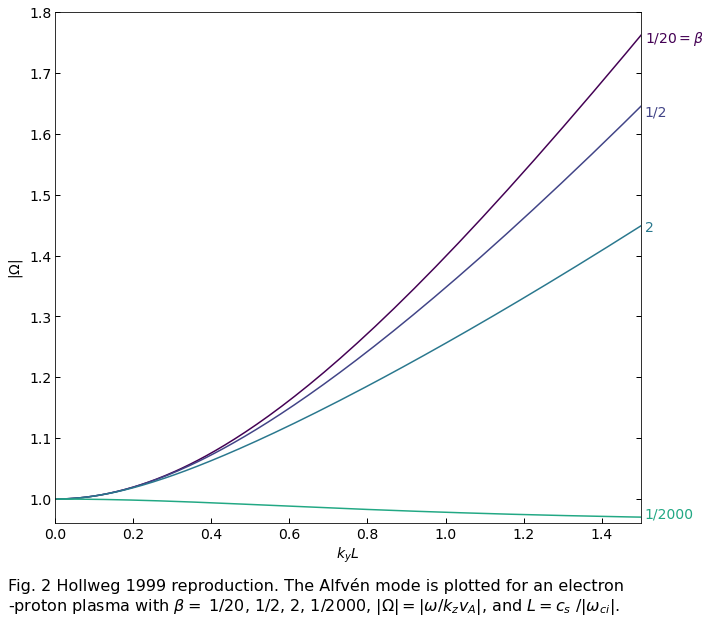

In [15]:
fs = 14  # default font size
figwidth, figheight = plt.rcParams["figure.figsize"]
figheight = 1.6 * figheight
fig = plt.figure(figsize=[figwidth, figheight])

# define colormap
cmap = plt.get_cmap("viridis")
slicedCM = cmap(np.linspace(0, 0.6, 4))

# plot
plt.plot(
    k_prime[0],
    big_omega[0],
    c=slicedCM[0],
    ms=1,
)
ax = plt.gca()
ax.plot(
    k_prime[1],
    big_omega[1],
    c=slicedCM[1],
    ms=1,
)
ax.plot(
    k_prime[2],
    big_omega[2],
    c=slicedCM[2],
    ms=1,
)
ax.plot(
    k_prime[3],
    big_omega[3],
    c=slicedCM[3],
    ms=1,
)

# adjust axes
ax.set_xlabel(r"$k_{y}L$", fontsize=fs)
ax.set_ylabel(r"$|\Omega|$", fontsize=fs)
ax.set_yscale("linear")
ax.set_xscale("linear")
ax.set_xlim(0, 1.5)
ax.set_ylim(0.96, 1.8)
ax.tick_params(
    which="both",
    direction="in",
    width=1,
    labelsize=fs,
    right=True,
    length=5,
)

# add labels for beta
plt.text(1.51, 1.75, "1/20$=\\beta$", c=slicedCM[0], fontsize=fs)
plt.text(1.51, 1.63, "1/2", c=slicedCM[1], fontsize=fs)
plt.text(1.51, 1.44, "2", c=slicedCM[2], fontsize=fs)
plt.text(1.51, 0.97, "1/2000", c=slicedCM[3], fontsize=fs)

# plot caption
txt = (
    "Fig. 2 Hollweg 1999 reproduction. The Alfvén mode is plotted for an electron\n"
    "-proton plasma with $\\beta=$ 1/20, 1/2, 2, 1/2000, $|\\Omega|=|\\omega / k_{z} v_{A}|$, and $L=c_{s}$ $/ |\\omega_{ci}|$.\n"
)

plt.figtext(-0.08, -0.21, txt, ha="left", transform=ax.transAxes, fontsize=16);

Note: Hollweg takes $k_{\perp}=k_{y}$ for k propogating in the $y$-$z$
plane as in the plot above. Contrarily, Bellan takes $k_{\perp}=k_{x}$
for k propogating in the $x$-$z$ plane.